## Aula 21. Código de Análise Estrutural via método dos deslocamentos
Este arquivo contém um código completo para resolução de pórticos planos, partindo desde a definição da estrutura até o cálculo de esforços em cada elemento. Vale ressaltar que o código é genérico, podendo ser usado para calcular qualquer pórtico plano que se tenha interesse. Basta para isso alterar as informações de entrada, como coordenadas e propriedades de cada seção.

Como problema exemplo vamos utilizar o exercício de pórtico plano das Aulas 19 e 20. Aqui vamos alterar a numeração dos nós e elementos, començando em zero para facilitar a utilização do código em Python:

![title](porticoex0.png)

Começamos então definindo o número de nós (n_nos) e número de elementos (n_el) da estrutura, assim como o número de cada nós e suas coordenadas no plano xy:

In [1]:
import numpy as np
from pylab import *
import matplotlib.pyplot as plt

#Dados do problema "Pórticos: EXEMPLO 02" da lista

n_nos=12 #Número de nós
n_el=15 #Número de elementos
a=0.3
# número de cada nó e coordenadas x e y dos mesmos
no = [i for i in range(12)]
x  = [2*30*a, 
      0, 0, 0, 0,
      30*a, 30*a, 30*a, 30*a, 
      2*30*a, 2*30*a, 2*30*a]

y  = [3*12*a, 
      0, 12*a, 2*12*a, 3*12*a, 
      0, 12*a, 2*12*a, 3*12*a, 
      0, 12*a, 2*12*a]

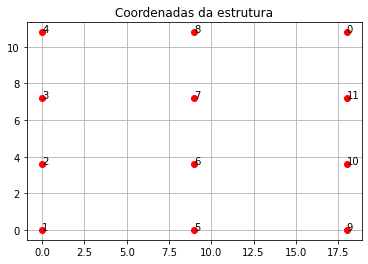

In [2]:
###############     Código apenas para geração da imagem    ##################
from IPython.display import display, Math, HTML

tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

#Código apenas para geração da imagem
fig = plt.figure()
ax = fig.add_subplot(111)

lines = plt.plot(x,y,'ro')
for i in no:
    plt.annotate(str(no[i]), xy=(x[i], y[i]), xytext=(x[i], y[i]))

title('Coordenadas da estrutura')
grid()

show()

O próximo passo é a definição da matriz de conectividade da estrutura [conec], responsável pela definição dos elementos e suas propriedades. Essa matriz possui uma linha para cada elemento, sendo que cada coluna indica, respectivamente: número do elemento, número da seção transversal do mesmo (que define suas propriedades), primeiro nó e segundo nó do elemento. 

As propriedades são definidas na matriz [secoes], que possui uma linha para cada seção distinta na estrutura. A primeira coluna indica o número da seção, a segunda a área da seção transversal, a terceira o módulo de elasticidade, a quarta o momento de inércia e a quinta a distância vertical entre a extremidade e a linha neutra. Vale ressaltar que essas propriedades são necessárias para pórticos planos, porém para outros casos, como pórticos espaciais, outras propriedades adicionais podem ser necessárias.

In [3]:
# Matriz de conectividade: [elemento, Número da seção, primeiro nó, segundo nó]
conec = np.array([[0,   1,   8,   0],
                  [1,   0,   1,   2],
                  [2,   0,   5,   6],
                  [3,   0,   9,   10],
                  [4,   0,   2,   3],
                  [5,   0,   6,   7],
                  [6,   0,   10,   11],
                  [7,   0,   3,   4],
                  [8,   0,   7,   8],
                  [9,   0,   11,   0],
                  [10,   1,   2,   6],
                  [11,   1,   6,   10],
                  [12,   1,   3,   7],
                  [13,   1,   7,   11],
                  [14,   1,   4,   8]]
                )

n_sec=1 # Número de seções distintas presentes na estrutura

# Matriz de Seções: [número da seção, área, módulo de elasticidade, momento de inércia, 
# distância vertical à linha neutra]
mod_elast=200*(10**9)
# pilar W250x167
# viga W410x114
secoes = np.array([[0, 21200*(10**(-6)), mod_elast, 98.2*(10**(-6)), (290/2)*10**(-3)],
                [1, 14600*(10**(-6)), mod_elast, 462*(10**(-6)), (262/2)*10**(-3)]]) 

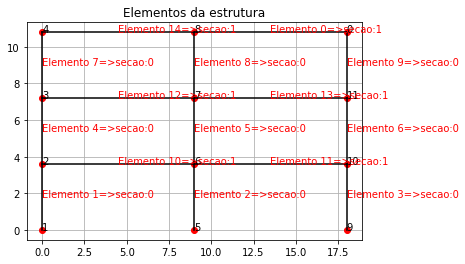

In [4]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

#Apenas para plotagem da figura
fig = plt.figure()
ax = fig.add_subplot(111)

lines = plt.plot(x,y,'ro')
for i in no:
    plt.annotate(str(no[i]), xy=(x[i], y[i]), xytext=(x[i], y[i]))

for i in range(n_el):
    plt.plot([x[conec[i,2]], x[conec[i,3]]],[y[conec[i,2]], y[conec[i,3]]],'k')
    plt.annotate('Elemento ' +str(i)+'=>secao:'+str(conec[i,1]), xy=((x[conec[i,2]]+x[conec[i,3]])/2, (y[conec[i,2]]+y[conec[i,3]])/2),
                 xytext=((x[conec[i,2]]+x[conec[i,3]])/2, (y[conec[i,2]]+y[conec[i,3]])/2),color='r')
title('Elementos da estrutura')
grid()

show()

O próximo passo é definir o carregamento. Esta definição se dá em duas etapas:

    1 - Carregamento nodal: aquele que ocorre diretamente em um nó da estrutura
    2 - Carregamento equivalente: carregamentos distribuídos ou concentrados em pontos diferentes dos nós

A seguir tem-se o caso das forças nodais, onde a matriz  [forcas]  é utilizada para definir as informações necessárias. Para cada nó em que ao menos uma força nodal atua, tem-se uma linha nessa matriz. A primeira coluna refere-se ao nó carregado, a segunda ao carregamento na direção x, a terceira em y e a quarta ao momento em z. Vale a pena ressaltar que é possível que apenas uma força atue em um nó, o que é indicado pelo valor zero nas demais forças.

In [5]:
# Carregamentos nodais (Fzão da estrutura)
n_forcas=3 #Número de nós na qual atuam forças
#Matriz de forças [nó (primeiro nó é o nó zero e não 1), força em x, força em y, momento]
forca_nodal = 30 * (10 ** 3)
forcas=np.matrix([[2,    forca_nodal,    0,    0], 
                [3,    forca_nodal,    0,    0],
                [4,    forca_nodal,    0,    0]]
            )

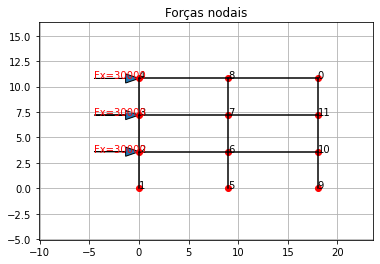

In [6]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

from pylab import *

#Apenas para plotagem da figura
fig = plt.figure()
ax = fig.add_subplot(111)

lines = plt.plot(x,y,'ro')
for i in no:
    plt.annotate(str(no[i-1]), xy=(x[i-1], y[i-1]), xytext=(x[i-1], y[i-1]))
l = max(abs(x[1]-x[0]),abs(y[1]-y[0]))
j = 0
if n_forcas != 0:
    for i in forcas[:,0]:
        if int(forcas[j,1]) != 0:
            arrow( x[int(i)]-np.sign(forcas[j,1])*0.25*l, y[int(i)],np.sign(forcas[j,1])*0.25*l,0,
                  length_includes_head = True, head_width = l*0.05 )
            plt.annotate('Fx='+str(forcas[j,1]), xy=(x[int(i)]-np.sign(forcas[j,1])*0.25*l, y[int(i)]),
                     xytext=(x[int(i)]-np.sign(forcas[j,1])*0.25*l, y[int(i)]),color='r')
        if int(forcas[j,2]) != 0:
            arrow( x[int(i)], y[int(i)]-np.sign(forcas[j,2])*0.25*l,0,np.sign(forcas[j,2])*0.25*l,
                  length_includes_head = True, head_width = l*0.05 )
            plt.annotate('Fy='+str(forcas[j,2]), xy=(x[int(i)], y[int(i)]-np.sign(forcas[j,2])*0.25*l),
                     xytext=(x[int(i)], y[int(i)]-np.sign(forcas[j,2])*0.25*l),color='r')
        if int(forcas[j,3]) != 0:
            circle1 = plt.Circle((x[int(i)], y[int(i)]), 0.1*l, color='r', fill=False)
            ax.add_artist(circle1)
            plt.annotate('Mz='+str(forcas[j,3]), xy=(x[int(i)]-np.sign(forcas[j,3])*0.125*l, 
                    y[int(i)]-np.sign(forcas[j,3])*0.125*l),xytext=(x[int(i)]-np.sign(forcas[j,3])*0.125*l, 
                    y[int(i)]-np.sign(forcas[j,3])*0.125*l),color='r')


        j = j+1

for i in range(n_el):
    plt.plot([x[conec[i,2]], x[conec[i,3]]],[y[conec[i,2]], y[conec[i,3]]],'k')    

left, right = xlim()
lower, upper = ylim()
xlim((left-0.25*l,right+0.25*l))
ylim((lower-0.25*l,upper+0.25*l))
title(u"Forças nodais")
grid()

show()

Já para as forças equivalentes, é preciso ter claro quais os casos que serão adotados. Aqui dois tipos de carregamentos são levados em consideração: carregamento uniformemente distribuído e força concentrada entre nós, ambos perpendiculares ao elemento.

A matriz  [w_eq]   é utilizada para definir os carregamentos equivalentes. Para cada carregamento corresponde uma linha na matriz, sendo as colunas usadas para informar o elemento carregado, o tipo de carregamento equivalente, a intensidade e a posição (para o caso de carregamento concentrado entre nós), respectivamente. Como já comentado, dois tipos são considerados aqui. O tipo 1 refere-se ao carregamento distribuído, enquanto o tipo 2 à força concentrada entre nós.

In [7]:
# Carregamentos equivalentes (Feq da estrutura)
n_eq=6 # número de elementos que contem carregamentos equivalentes
# Matriz de carregamento equivalente = [elemento, tipo de carregamento, intensidade, posição (para o caso de carregamento concentrado entre nós)]
carreg_uniforme=18*(10**3)
w_eq=np.array([[10, 1, -carreg_uniforme, 0],
            [11, 1, -carreg_uniforme, 0],
            [12, 1, -carreg_uniforme, 0],
            [13, 1, -carreg_uniforme, 0],
            [14, 1, -carreg_uniforme, 0],
            [0, 1, -carreg_uniforme, 0]
            ])
# LEMBRETE: os sinais das forças devem seguir o sistema LOCAL do elemento!

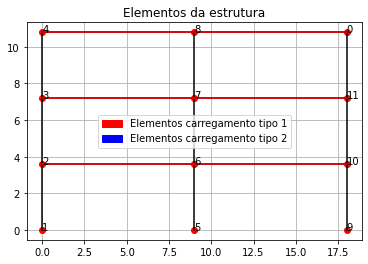

In [8]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

#Apenas para plotagem da figura
import matplotlib.patches as mpatches

fig = plt.figure()
ax = fig.add_subplot(111)

lines = plt.plot(x,y,'ro')
for i in no:
    plt.annotate(str(no[i-1]), xy=(x[i-1], y[i-1]), xytext=(x[i-1], y[i-1]))
for i in range(n_el):
    plt.plot([x[conec[i,2]], x[conec[i,3]]],[y[conec[i,2]], y[conec[i,3]]],'k')
    
if n_eq != 0:
    j = 0
    for i in w_eq[:,0]:
        if w_eq[j,1]==1:
            fig1 = plt.plot([x[conec[int(i),2]], x[conec[int(i),3]]],[y[conec[int(i),2]], y[conec[int(i),3]]],'r')
        elif w_eq[j,1]==2:
            fig2 = plt.plot([x[conec[int(i),2]], x[conec[int(i),3]]],[y[conec[int(i),2]], y[conec[int(i),3]]],'b')
        j = j + 1

red_patch = mpatches.Patch(color='red', label=u'Elementos carregamento tipo 1')
blue_patch = mpatches.Patch(color='blue', label=u'Elementos carregamento tipo 2')
plt.legend(handles=[red_patch,blue_patch])


    
title(u'Elementos da estrutura')
grid()

show()

Por fim, resta definir as condições de contorno do problema. Para isso, a matriz  [GDL_rest]   com número de linhas igual ao número de nós que contém pelo menos uma restrição (tipo de apoio) deve ser informada. Já para as colunas, a primeira indica o número do nó restringido e as três colunas seguintes referem-se aos graus de liberdade x, y e rotação desse nó, respectivamente. Caso apresente valor 1, isso indica que o respectivo GDL desse nó está restringido, caso seja zero, o GDL está liberado. Vale ressaltar que caso um nó não apresente restrições, ele não deve ser incluído na matriz.

In [9]:
# Apoios
n_rest=3  #número de nós restringidos
#Matriz de condições de contorno 
# [número do nó, restringido_x, restringido_y, restringido_theta] (1 para restringido, e 0 para livre)
GDL_rest=np.array([[1, 1, 1, 0],
                   [5, 1, 1, 0],
                   [9, 1, 1, 0]])  


Essa matriz de condições de contorno indica que os seguintes nós e graus de liberdade estão restringidos: 

In [10]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

txt = r'\begin{align}'
j = 0
for i in GDL_rest[:,0]:
    txt = txt + 'No' + str(GDL_rest[j,0]) + ':'
    if GDL_rest[j,1] == 1:
        txt = txt+' x=fixo,'
    if GDL_rest[j,2] == 1:
        txt = txt+' y=fixo,'
    if GDL_rest[j,3] == 1:
        txt = txt+' rotacao=fixo,'
    txt = txt+'\\\\'
    j = j + 1
txt = txt + '\end{align}'
display(Math(txt))

<IPython.core.display.Math object>

# Cálculo da estrutura

Todas as informações necessárias para definição da estrutura já foram passadas. Assim, as próximas linhas de código são independentes do problema em questão.

O cálculo da estrutura inicia pela matriz de rigidez da mesma, considerando a contribuição de um elemento por vez, conforme trecho de código a seguir:

In [11]:
# CALCULO DA ESTRUTURA
GDL=3*n_nos  #graus de liberdade da estrutura
K=np.zeros((GDL,GDL)) #matriz rigidez global

# Cálculo da matriz de cada elemento
for el in range(n_el):
    #print(el)
    #calculo do comprimento do elemento el
    no1=conec[el,2]
    no2=conec[el,3]
    #L=abs(x(no2)-x(no1))
    L = np.sqrt((x[no2] - x[no1])**2 + (y[no2] - y[no1])**2)
    #Propriedades
    A = secoes[conec[el,1],1]
    E = secoes[conec[el,1],2]
    Iz = secoes[conec[el,1],3]
    #Cossenos diretores a partir das coordenadas dos ns do elemento
    c = (x[no2] - x[no1])/L	# cosseno
    s = (y[no2] - y[no1])/L	#  seno
    # Matriz de transformação do elemento "el"
    T=np.array([[c, s, 0, 0, 0, 0],
                [-s, c, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0],
                [0, 0, 0, c, s, 0],
                [0, 0, 0,-s, c, 0],
                [0, 0, 0, 0, 0, 1]])
    # Construo da matriz de rigidez em coordenadas locais
    k1=E*A/L
    k2=12*E*Iz/L**3
    k3=6*E*Iz/L**2
    k4=4*E*Iz/L
    k5=k4/2
    k=np.array([[k1, 0, 0, -k1, 0, 0],
                [0, k2, k3, 0, -k2, k3],
                [0, k3, k4, 0, -k3, k5],
                [-k1, 0, 0,    k1, 0, 0],
                [0, -k2, -k3, 0, k2, -k3],
                [0, k3, k5, 0, -k3, k4]])
    # Matriz de rigidez em coordenadas globais  
    kg=np.dot(np.transpose(T),np.dot(k,T))
  
    #Determinando matriz de incidência cinemática:
    b = np.zeros((6,GDL))
    i=no1
    j=no2
    b[0,3*i] = 1
    b[1,3*i+1] = 1
    b[2,3*i+2] = 1
    b[3,3*j] = 1
    b[4,3*j+1] = 1
    b[5,3*j+2] = 1
    #Expandindo e convertendo a matriz do elemento para coordenadas globais:
    Ki=np.dot(np.transpose(b),np.dot(kg,b))
    #Somando contribuição do elemento para a matriz de rigidez global:
    K = K + Ki

A matriz de rigidez da estrutura $(\textbf{K})$ é então:

In [12]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

txt = r'\begin{align}\begin{bmatrix}'
for j in range(GDL):
    for i in range(GDL-1):
        txt+=str(np.round(K[j,i],2))+'&'
    
    txt+= str(np.round(K[j,GDL-1],2)) + '\\\\'
txt+= '\end{bmatrix}\end{align}'
display(Math(txt))

<IPython.core.display.Math object>

A seguir tem-se o cálculo do vetor de forças:

In [13]:
# Vetor de forcas Global
F=np.zeros((GDL,1))
for i in range(n_forcas):
    F[int(3*forcas[i,0])]=forcas[i,1]
    F[int(3*forcas[i,0])+1]=forcas[i,2]
    F[int(3*forcas[i,0])+2]=forcas[i,3]


In [14]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

txt = r'\begin{align}\quad\boldsymbol F=\begin{bmatrix}'
for j in range(GDL):    
    txt+= str(np.round(F[j,0],2)) + '\\\\'
txt+= '\end{bmatrix}\end{align}'
display(Math(txt))

<IPython.core.display.Math object>

Agora é necessário calcular o vetor de forças equivalentes, considerando a contribuição de um carregamento equivalente por vez:

In [15]:
# Construção do vetor de foras equivalentes
Feq=np.zeros((GDL,1))
for i in range(n_eq):
    tipo=int(w_eq[i,1])   #tipo de força equivalente
    el=int(w_eq[i,0])     #elemento onde está aplicada
    if tipo==1: #Carregamento distribuído
        f=np.zeros((6,1))
        no1=conec[el,2]
        no2=conec[el,3]
        L = np.sqrt((x[no2] - x[no1])**2 + (y[no2] - y[no1])**2)
        w=w_eq[i,2]
        f[0]=0
        f[1]=+w*L/2
        f[2]=+w*L**2/12
        f[3]=0
        f[4]=+w*L/2
        f[5]=-w*L**2/12
        #Cossenos diretores a partir das coordenadas dos ns do elemento
        c = (x[no2] - x[no1])/L	# cosseno
        s = (y[no2] - y[no1])/L	#  seno
        # Matriz de transformação do elemento "el"
        T=np.array([[c, s, 0, 0, 0, 0],
                    [-s, c, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0, 0],
                    [0, 0, 0, c, s, 0],
                    [0, 0, 0,-s, c, 0],
                    [0, 0, 0, 0, 0, 1]])
        #feqTT=np.dot(np.transpose(T),f)
        feq=np.matmul(np.transpose(T), f)
        Feq[3*no1]=Feq[3*no1]+feq[0]
        Feq[3*no1+1]=Feq[3*no1+1]+feq[1]
        Feq[3*no1+2]=Feq[3*no1+2]+feq[2]
        Feq[3*no2]=Feq[3*no2]+feq[3]
        Feq[3*no2+1]=Feq[3*no2+1]+feq[4]
        Feq[3*no2+2]=Feq[3*no2+2]+feq[5]
    elif tipo==2: ## carga aplicada a uma distancia a do nó i
        f=np.zeros((6,1))
        no1=conec[el,2]
        no2=conec[el,3]
        L = np.sqrt((x[no2] - x[no1])**2 + (y[no2] - y[no1])**2)
        a=w_eq[i,3]
        b=L-a
        p=w_eq[i,2]
        f[0]=0
        f[1]=+p*b**2*(3*a+b)/L**3
        f[2]=+p*a*b**2/L**2
        f[3]=0
        f[4]=+p*a**2*(a+3*b)/L**3
        f[5]=-p*a**2*b/L**2
        #Cossenos diretores a partir das coordenadas dos nós do elemento
        c = (x[no2] - x[no1])/L # cosseno
        s = (y[no2] - y[no1])/L #  seno
        # Matriz de transformação do elemento "el"
        T=np.array([[c, s, 0, 0, 0, 0],
                    [-s, c, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0, 0],
                    [0, 0, 0, c, s, 0],
                    [0, 0, 0,-s, c, 0],
                    [0, 0, 0, 0, 0, 1]])
        #feqTT=np.dot(np.transpose(T),f)
        feq=np.matmul(np.transpose(T), f)
        Feq[3*no1]=Feq[3*no1]+feq[0]
        Feq[3*no1+1]=Feq[3*no1+1]+feq[1]
        Feq[3*no1+2]=Feq[3*no1+2]+feq[2]
        Feq[3*no2]=Feq[3*no2]+feq[3]
        Feq[3*no2+1]=Feq[3*no2+1]+feq[4]
        Feq[3*no2+2]=Feq[3*no2+2]+feq[5]


In [16]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

txt = r'\begin{align}\quad\boldsymbol F_{eq}=\begin{bmatrix}'
for j in range(GDL):    
    txt+= str(np.round(Feq[j,0],2)) + '\\\\'
txt+= '\end{bmatrix}\end{align}'
display(Math(txt))

<IPython.core.display.Math object>

Tem-se calculados até aqui a matriz de rigidez $(\textbf{K})$, o vetor de forças nodais $(\textbf{F})$ e o vetor de forças equivalentes $(\textbf{F}_{eq})$. O próximo passo é aplicar as condições de contorno ao problema, de modo a possibilitar a obtenção de uma solução para o mesmo. Para isso, elimina-se as linhas de $\textbf{K}$, $\textbf{F}$ e $\textbf{F}_{eq}$ e colunas de $\textbf{K}$ referentes aos GDL restringidos. 

Uma maneira computacionalmente simples e eficiente de se fazer isso é zerar os termos das linhas e colunas que seriam eliminadas de $\textbf{K}$, $\textbf{F}$ e $\textbf{F}_{eq}$ e atribuir o valor 1 aos termos da diagonal da matriz $\textbf{K}$ que seriam eliminados. O trecho de código a seguir refere-se a esse passo:

In [17]:
# guardamos os originais de K e F
Kg=np.copy(K)
#Kg[:] = K[:]

Fg=F+Feq
# Aplicar Restrições (condições de contorno)
for k in range(n_rest):
    # Verifica se há restrição na direção x
    if GDL_rest[k,1]==1:
        j=3*GDL_rest[k,0]
        #Modificar Matriz de Rigidez
        for i in range(GDL):
            Kg[j,i]=0   #zera linha
            Kg[i,j]=0   #zera coluna
        Kg[j,j]=1       #valor unitário na diagonal principal
        Fg[j]=0
    # Verifica se há restrição na direção y
    if GDL_rest[k,2]==1:
        j=3*GDL_rest[k,0]+1
        #Modificar Matriz de Rigidez
        for i in range(GDL):
            Kg[j,i]=0   #zera linha
            Kg[i,j]=0   #zera coluna
        Kg[j,j]=1       #valor unitário na diagonal principal
        Fg[j]=0
    # Verifica se há restrição na rotação
    if GDL_rest[k,3]==1:
        j=3*GDL_rest[k,0]+2
        #Modificar Matriz de Rigidez
        for i in range(GDL):
            Kg[j,i]=0   #zera linha
            Kg[i,j]=0   #zera coluna
        Kg[j,j]=1       #valor unitário na diagonal principal
        Fg[j]=0


Para ilustrar esse processo, a matriz de rigidez restringida da estrutura resulta em:

In [18]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

txt = r'\begin{align}\begin{bmatrix}'
for j in range(GDL):
    for i in range(GDL-1):
        txt+=str(np.round(Kg[j,i],2))+'&'
    
    txt+= str(np.round(Kg[j,GDL-1],2)) + '\\\\'
txt+= '\end{bmatrix}\end{align}'
display(Math(txt))

<IPython.core.display.Math object>

Após a aplicação das condições de contorno, pode-se obter os deslocamentos nos nós da estrutura resolvendo o sistema de equações lineares $\textbf{K}\textbf{d}=\textbf{F}+\textbf{F}_{eq}$:

In [19]:
# Calculo dos deslocamentos
desloc=np.linalg.solve(Kg,Fg)    

In [20]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)
from decimal import Decimal

txt = r'\begin{align}\quad\boldsymbol d=\begin{bmatrix}'
for j in range(GDL):
    if desloc[j,0] == 0:
        txt+= str(desloc[j,0]) + '\\\\'
    else:    
        txt+= str("{:.2E}".format(Decimal(desloc[j,0]))) + '\\\\'
txt+= '\end{bmatrix}\end{align}'
display(Math(txt))

<IPython.core.display.Math object>

Tendo calculado os deslocamentos, pode-se agora obter as reações $(\textbf{R})$ usando a expressão $\textbf{R} = \textbf{K}\textbf{d}-\textbf{F}_{eq}$:

In [21]:
# Reações
reacoes=np.matmul(K, desloc)-Feq
#reacoes=K*desloc-Feq

In [22]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)
from decimal import Decimal

txt = r'\begin{align}\quad\boldsymbol R=\begin{bmatrix}'
for j in range(GDL):
    if reacoes[j,0] == 0:
        txt+= str(reacoes[j,0]) + '\\\\'
    else:    
        txt+= str("{:.2E}".format(Decimal(reacoes[j,0]))) + '\\\\'
txt+= '\end{bmatrix}\end{align}'
display(Math(txt))

<IPython.core.display.Math object>

In [23]:
# Esforços nos elementos
f_el=np.zeros((n_el,6))
N = np.zeros((n_el,1))
Mmax = np.zeros((n_el,1))
Smax = np.zeros((n_el,1))
Falha = np.zeros((n_el,1))
Sadm=248.2e6 #colocar valor do pdf do projeto 
peso=0
ro=7861
for el in range(n_el):
    #calculo do comprimento do elemento el
    no1=conec[el,2]
    no2=conec[el,3]
    #L=abs(x(no2)-x(no1))
    L = np.sqrt((x[no2] - x[no1])**2 + (y[no2] - y[no1])**2)
    #Propriedades
    A = secoes[conec[el,1],1]
    E = secoes[conec[el,1],2]
    Iz = secoes[conec[el,1],3]
    cc = secoes[conec[el,1],4]
    #calculo peso
    peso=peso+A*L*ro
    #Cossenos diretores a partir das coordenadas dos ns do elemento
    c = (x[no2] - x[no1])/L # cosseno
    s = (y[no2] - y[no1])/L #  seno
    # Matriz de transformação do elemento "el"
    T=np.array([[c, s, 0, 0, 0, 0],
                [-s, c, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0],
                [0, 0, 0, c, s, 0],
                [0, 0, 0,-s, c, 0],
                [0, 0, 0, 0, 0, 1]])
    # Construção da matriz de rigidez em coordenadas locais
    k1=E*A/L
    k2=12*E*Iz/L**3
    k3=6*E*Iz/L**2
    k4=4*E*Iz/L
    k5=k4/2
    ke=np.array([[k1, 0, 0, -k1, 0, 0],
                [0, k2, k3, 0, -k2, k3],
                [0, k3, k4, 0, -k3, k5],
                [-k1, 0, 0,    k1, 0, 0],
                [0, -k2, -k3, 0, k2, -k3],
                [0, k3, k5, 0, -k3, k4]])
   #pega os valores dos deslocamentos dos nós do elemento "el"
    u1 = desloc[no1*3]
    u2 = desloc[no2*3]
    v1 = desloc[no1*3+1]
    v2 = desloc[no2*3+1]
    th1=desloc[no1*3+2]
    th2=desloc[no2*3+2]
    d_g=np.array([u1, v1, th1, u2, v2, th2])
    d_el=np.matmul(T, d_g)
    #d_el=T*d_g    

    ## forças equivalentes: recalcula vetor de feq. no sistema local
    aux = []
    cont = [0];
    for temp in w_eq[:,0]:
        if int(temp) ==el:
            aux = cont[:]
        cont[0] = cont[0] + 1
    if len(aux)==0:
        feqq=0
    else:
        aux = int(aux[0])
        tipo=w_eq[aux,1]   #tipo de força equivalente
        if tipo==1:
            w=w_eq[aux,2]
            feqq=np.zeros((6,1))
            feqq[0]=0
            feqq[1]=+w*L/2
            feqq[2]=+w*L**2/12
            feqq[3]=0
            feqq[4]=+w*L/2
            feqq[5]=-w*L**2/12
        elif tipo==2:
            a=w_eq[aux,3]
            b=L-a
            p=w_eq[aux,2]
            feqq=np.zeros((6,1))
            feqq[0]=0
            feqq[1]=+p*b**2*(3*a+b)/L**3
            feqq[2]=+p*a*b**2/L**2
            feqq[3]=0
            feqq[4]=+p*a**2*(a+3*b)/L**3
            feqq[5]=-p*a**2*b/L**2
        
    ## esforços locais atuantes no elemento "el": cada linha da matriz f_el
    #contem os esforços de um elemento = [fx_1' fy_1' mz_1' fx_2' fy_2' mz_2']
    f_el[el,:] = np.transpose(np.matmul(ke, d_el)-feqq)
    # Esforços para cálculo de tensão
    N=abs(f_el[el,0])
    Mzi=abs(f_el[el,2])
    Mzj=abs(f_el[el,5])
    if el>0 and el<10:
        aux=np.array([Mzi,Mzj])
        Mmax[el]=aux.max()
    else:
        Mvao=0
        aux=np.array([Mzi,Mzj,Mvao])
        Mmax[el]=aux.max()
        
    # Cálculo da tensão
    Smax[el]=N/A+Mmax[el]/Iz*cc
    
    # Critério de Falha
    if Smax[el]>Sadm:
        Falha[el]=1



In [24]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)
from decimal import Decimal

txt = r'\begin{align} f = \begin{bmatrix}'
for j in range(n_el):
    for i in range(5):
        if f_el[j,i] == 0:
            txt+= str(f_el[j,i]) + '&'
        else:    
            txt+= str("{:.2E}".format(Decimal(f_el[j,i]))) + '&'    
    if f_el[j,i] == 0:
        txt+= str(f_el[j,5]) + '\\\\'
    else:    
        txt+= str("{:.2E}".format(Decimal(f_el[j,5]))) + '\\\\'    
txt+= '\end{bmatrix}\end{align}'
display(Math(txt))

txt = r'\begin{align} \sigma = \begin{bmatrix}'
for j in range(n_el):
    if Smax[j,0] == 0:
        txt+= str(Smax[j,0]) + '\\\\'
    else:    
        txt+= str("{:.2E}".format(Decimal(Smax[j,0]))) + '\\\\'    
txt+= '\end{bmatrix}\end{align}'
display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [25]:
print(Mmax)

[[141903.29954365]
 [ 76961.6829246 ]
 [123764.85525869]
 [123273.46181666]
 [ 24167.75479201]
 [ 57636.00016329]
 [ 73047.15084551]
 [ 32857.96272591]
 [ 26303.87052117]
 [ 68273.98508956]
 [237060.25253893]
 [183439.18878463]
 [180115.94166153]
 [127546.59904132]
 [168207.17006482]]


In [26]:
print(f_el)

[[ 3.41037315e+04  8.91810349e+04  1.41903300e+05 -3.41037315e+04
   7.28189651e+04 -6.82739851e+04]
 [ 1.79517771e+05  2.13782453e+04  2.91038305e-11 -1.79517771e+05
  -2.13782453e+04  7.69616829e+04]
 [ 5.40964458e+05  3.43791265e+04  0.00000000e+00 -5.40964458e+05
  -3.43791265e+04  1.23764855e+05]
 [ 2.51517771e+05  3.42426283e+04  0.00000000e+00 -2.51517771e+05
  -3.42426283e+04  1.23273462e+05]
 [ 1.30723791e+05 -7.75512034e+03 -2.41677548e+04 -1.30723791e+05
   7.75512034e+03 -3.75067841e+03]
 [ 3.60448810e+05  3.07515432e+04  5.30695552e+04 -3.60448810e+05
  -3.07515432e+04  5.76360002e+04]
 [ 1.56827399e+05  3.70035772e+04  6.01657270e+04 -1.56827399e+05
  -3.70035772e+04  7.30471508e+04]
 [ 6.59611992e+04 -1.75240428e+04 -3.02285912e+04 -6.59611992e+04
   1.75240428e+04 -3.28579627e+04]
 [ 1.85219836e+05  1.34203113e+04  2.20092501e+04 -1.85219836e+05
  -1.34203113e+04  2.63038705e+04]
 [ 7.28189651e+04  3.41037315e+04  5.44994482e+04 -7.28189651e+04
  -3.41037315e+04  6.8273

In [27]:
print(f_el)

[[ 3.41037315e+04  8.91810349e+04  1.41903300e+05 -3.41037315e+04
   7.28189651e+04 -6.82739851e+04]
 [ 1.79517771e+05  2.13782453e+04  2.91038305e-11 -1.79517771e+05
  -2.13782453e+04  7.69616829e+04]
 [ 5.40964458e+05  3.43791265e+04  0.00000000e+00 -5.40964458e+05
  -3.43791265e+04  1.23764855e+05]
 [ 2.51517771e+05  3.42426283e+04  0.00000000e+00 -2.51517771e+05
  -3.42426283e+04  1.23273462e+05]
 [ 1.30723791e+05 -7.75512034e+03 -2.41677548e+04 -1.30723791e+05
   7.75512034e+03 -3.75067841e+03]
 [ 3.60448810e+05  3.07515432e+04  5.30695552e+04 -3.60448810e+05
  -3.07515432e+04  5.76360002e+04]
 [ 1.56827399e+05  3.70035772e+04  6.01657270e+04 -1.56827399e+05
  -3.70035772e+04  7.30471508e+04]
 [ 6.59611992e+04 -1.75240428e+04 -3.02285912e+04 -6.59611992e+04
   1.75240428e+04 -3.28579627e+04]
 [ 1.85219836e+05  1.34203113e+04  2.20092501e+04 -1.85219836e+05
  -1.34203113e+04  2.63038705e+04]
 [ 7.28189651e+04  3.41037315e+04  5.44994482e+04 -7.28189651e+04
  -3.41037315e+04  6.8273